In [133]:
import numpy as np
import matplotlib.pyplot as plt

In [134]:
def initialize_membership_matrix(num_samples, num_clusters):
    membership_mat = np.random.rand(num_clusters, num_samples)
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

def initial_centroids(num_clusters, num_features):
    return np.random.rand(num_clusters, num_features)
    

In [135]:
def epsilon_insensitive_loss(y_true, y_pred, epsilon):
    # Calculate absolute errors
    errors = np.abs(y_true - y_pred)
    # Apply epsilon-insensitive penalty
    loss = np.maximum(0, errors - epsilon)
    return np.mean(loss)

In [136]:
def update_membership_matrix(data, centroids, num_clusters, epsilon, m):
    # Update the membership matrix
    num_samples = data.shape[0]
    membership_mat = np.zeros((num_clusters, num_samples)).astype('float128')
    for i in range(num_samples):
        denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m))) 
        for k in range(num_clusters):
            membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
            if np.isinf(membership_mat[k, i]):
                membership_mat[k, i] = 1
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

In [137]:
from scipy.optimize import minimize


EPSILON = .01
DATA = None
L    = None


def objective(x):
    global EPSILON 
    global DATA
    global L
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    temp = 0
    for k in range(len(a)):
        temp += (a[k] - b[k])*DATA[k,L]
    return temp + sum(a + b) * EPSILON

def constraint(x):
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    return sum(a) - sum(b)

def Lambda(num_samples, membership_mat, i_index, m):
    initial_guess = [0.] * num_samples*2
    bounds_a = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds_b = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds = np.concatenate((bounds_a, bounds_b))
    constraint_eq = {'type': 'eq', 'fun': constraint}
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraint_eq, method='SLSQP')

    return result.x[:len(result.x)//2], result.x[len(result.x)//2:]

def update_centroid(data, num_samples, num_features, num_clusters, centroids, epsilon, membership_mat, m, alpah):
    global EPSILON, DATA, L
    EPSILON = epsilon
    DATA = data
    for i in range(num_clusters):
        for j in range(num_features):
            L = j
            l1, l2 = Lambda(num_samples, membership_mat, i, m)
            f, s = 0., 0.
            for ns in range(num_samples):
                if 0<l1[ns]<membership_mat[i, ns]:
                    f += data[ns][j] + epsilon
                if 0<l2[ns]<membership_mat[i, ns]:
                    s += data[ns][j] - epsilon
            # print(f, end=":")
            # print(s)
            centroids[i][j] = alpah * (f+s) / np.unique(np.concatenate((l1, l2))).shape[0] + (1-alpah) * centroids[i][j]
    
    return centroids
        

In [138]:
def fuzzy_cmeans(data, num_clusters, max_iter, epsilon, m, alpha):
    num_samples, num_features = data.shape
    cen_mat = initial_centroids(num_clusters, num_features)
    for _ in range(max_iter):
        print(_, end=',')
        mem_mat = update_membership_matrix(data, cen_mat, num_clusters, epsilon, m)
        cen_mat = update_centroid(data, num_samples, num_features, num_clusters, cen_mat, epsilon, mem_mat, m, alpha)
        
    print(cen_mat)
    print(mem_mat)
    return cen_mat, mem_mat
        

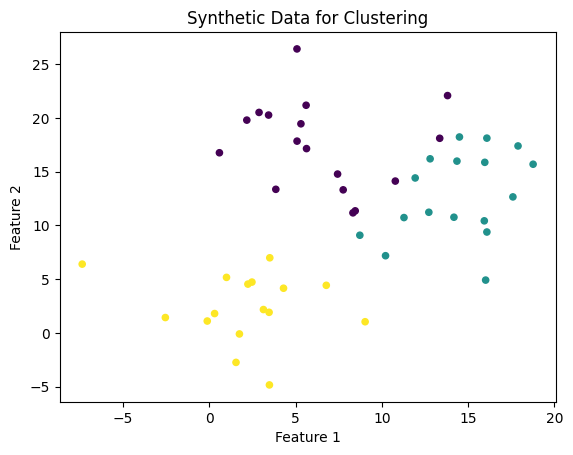

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,

/media/mrj/documents/AI/MachineLearning/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/media/mrj/documents/AI/MachineLearning/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/media/mrj/documents/AI/MachineLearning/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,[[ 7.50054819 11.10846901]
 [ 8.00564666 10.2017106 ]
 [ 7.58769046 10.98236255]]
[[3.41867497e-01 9.99999997e-01 1.14762065e-13 5.40422000e-03
  1.38643076e-01 8.17863735e-01 2.57176393e-01 5.98316684e-02
  7.71027526e-01 2.01094059e-03 8.40018888e-01 6.75188957e-03
  5.92181803e-06 9.97281457e-01 7.96812889e-01 9.54481869e-01
  2.38975044e-03 4.09880129e-04 8.38367671e-01 2.89485195e-01
  8.11392940e-01 2.45933504e-04 3.07856590e-01 3.39308225e-05
  9.99999638e-01 1.56457263e-04 2.98215145e-01 9.61443040e-01
  4.27758867e-04 8.64990392e-01 3.01020127e-03 7.59865943e-01
  8.58248389e-01 7.52120071e-01 7.74561390e-01 1.11464588e-04
  2.14610128e-06 7.49348978e-01 9.72828844e-01 5.62829536e-03
  5.74547981e-03 3.07781145e-01 5.99009130e-03 1.99235712e-01
  2.80798063e-01 1.59122949e-03 2.29329804e-01 5.52521430e-07
  9.23056743e-01 6.56291522e-04]
 [8.55895715e-03 6.46658781e-33 1.00000000

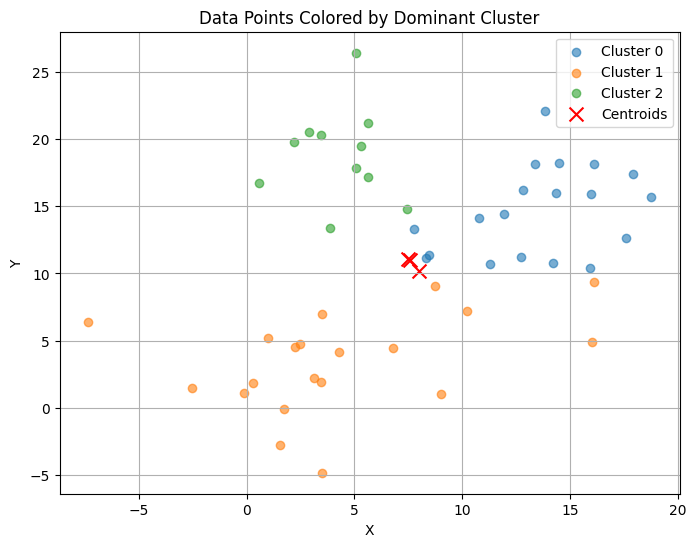

Normalized Mutual Information (NMI): 0.610533258159871


In [139]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score



num_clusters=3
num_samples = 50

# Generate synthetic data with clusters
X, y = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=4, random_state=42)
X += 10



# Visualize the generated data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
plt.title('Synthetic Data for Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


centroids ,membership_mat = fuzzy_cmeans(data=X, num_clusters=num_clusters, max_iter=50, epsilon=0, m=1.01, alpha=.8)

max_membership_cluster = np.argmax(membership_mat, axis=0)
# Plot data points with colors based on their corresponding centroids
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = X[max_membership_cluster == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title('Data Points Colored by Dominant Cluster')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()
# Assuming 'y' contains the true cluster labels and 'max_membership_cluster' contains the cluster labels assigned by your fuzzy clustering algorithm
nmi = normalized_mutual_info_score(y, max_membership_cluster)
print("Normalized Mutual Information (NMI):", nmi)